<a href="https://colab.research.google.com/github/IlhamThrq/ComputerVision_TRK25/blob/main/Jobsheet03_ilham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JOBSHEET 03: TEKNIK REGRESI GAMBAR

## Praktikum D1: Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

### 1. Setup & Generator Dataset

Kita akan membuat dataset citra 64×64 berisi satu lingkaran putih di latar hitam. Tiap gambar punya radius dan titik pusat acak.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample gambar lingkaran
def make_sample(img_size=64, min_r=5, max_r=20):
    # Tentukan radius acak antara min_r dan max_r
    r = np.random.randint(min_r, max_r + 1)

    # Buat kanvas hitam ukuran (img_size x img_size)
    img = np.zeros((img_size, img_size), dtype=np.uint8)

    # Tentukan koordinat acak untuk pusat lingkaran
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)

    # Gambar lingkaran putih terisi penuh di atas kanvas hitam
    cv2.circle(img, (cx, cy), r, (255,), -1)

    # Normalisasi piksel ke rentang [0, 1]
    img = (img / 255.0).astype(np.float32)

    # Ubah ke format 3-channel agar kompatibel dengan CNN
    img3 = np.stack([img, img, img], axis=-1)

    return img3, float(r), (cx, cy)


### 2. "Tebak Apa??" Tampilkan Contoh Gambar TANPA Label

Tugas kecil: Lihat gambar-gambar berikut. Kira-kira variabel kontinu apa yang ingin kita prediksi?

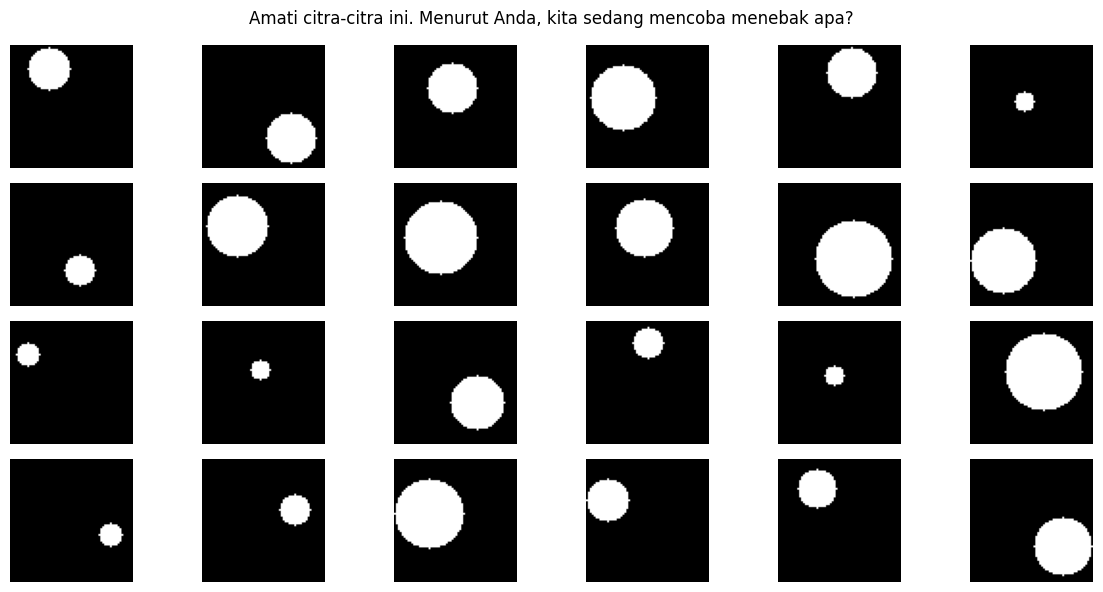

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Tampilkan grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?", fontsize=12)
plt.tight_layout()
plt.show()


Diskusi cepat:

*  Apakah yang berubah dari gambar ke gambar?
> JAWABAN: Yang berubah dari satu gambar ke gambar lainnya adalah ukuran lingkaran (radius) dan posisi pusatnya (cx, cy). Setiap gambar menampilkan lingkaran dengan ukuran dan lokasi acak di dalam bidang hitam.

*  Apakah ukuran lingkaran berkaitan dengan sesuatu yang bisa “diukur” sebagai angka?
> JAWABAN: Ya, ukuran lingkaran dapat dinyatakan sebagai angka radius (panjang jari-jari). Nilai ini bersifat numerik dan dapat dijadikan target regresi bagi model pembelajaran mesin untuk diprediksi dari citra.

*  Apakah posisi pusat juga bisa jadi target?
> JAWABAN: Bisa. Koordinat pusat lingkaran (cx, cy) juga merupakan nilai numerik yang bisa dijadikan target tambahan, misalnya jika tujuan model adalah memprediksi lokasi objek dalam gambar selain ukurannya.


### 3. Buka Jawaban: Target yang Ingin Diprediksi


Di D1 ini, target utamanya adalah radius lingkaran (nilai kontinu). Mari ungkap labelnya di gambar yang sama

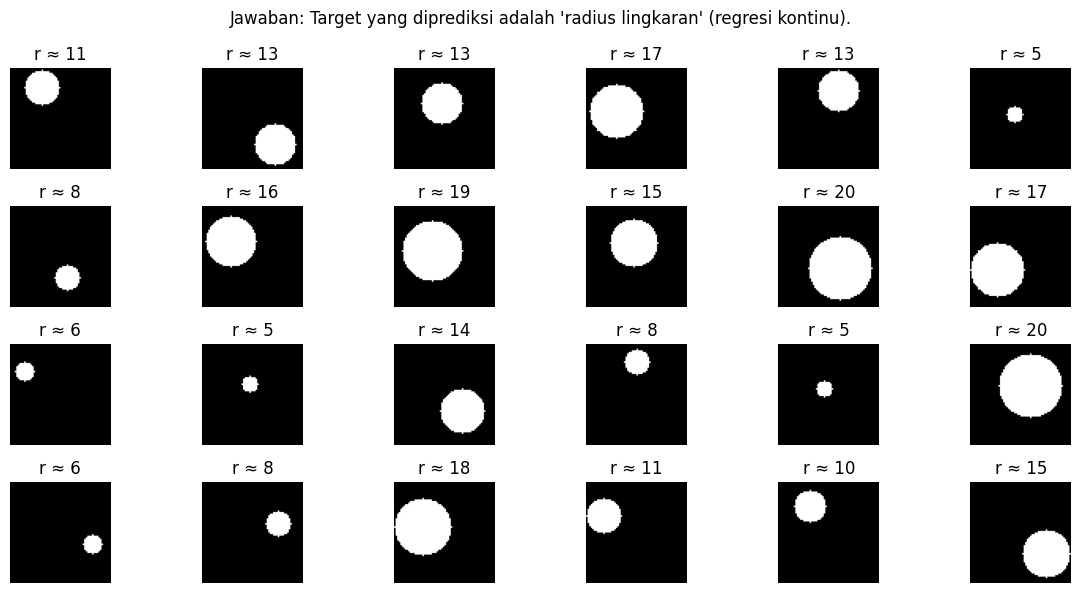

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).", fontsize=12)
plt.tight_layout()
plt.show()


### 4. Latih CNN Kecil untuk Memprediksi Radius

Kalau sudah paham “tebakannya”, mari buktikan bahwa CNN bisa mempelajari hubungan “pola lingkaran → angka radius”.

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Bagi data menjadi train dan test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

# Kompilasi model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Latih model
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi model
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
MAE = 0.985 | RMSE = 1.199 | R² = 0.935


Plot history & True vs Predicted

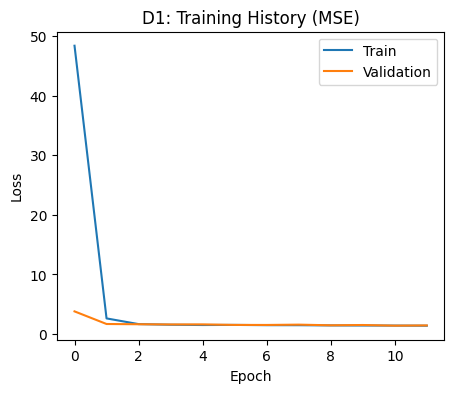

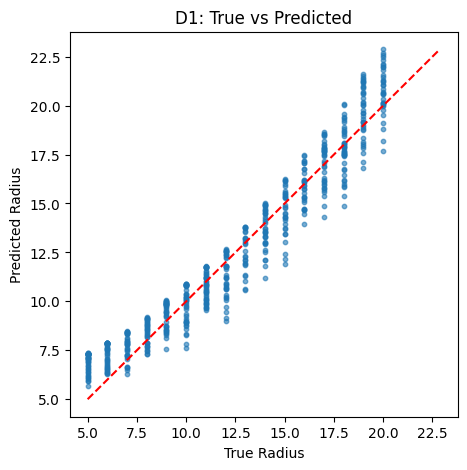

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter plot: True vs Predicted radius
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


### 5. Tantangan Mini

*	Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R².
* Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
* Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus; metrik evaluasi apa yang cocok?



=== Eksperimen 1: Rentang radius 8–28 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[Radius 8–28] MAE=1.180 | RMSE=1.434 | R²=0.937


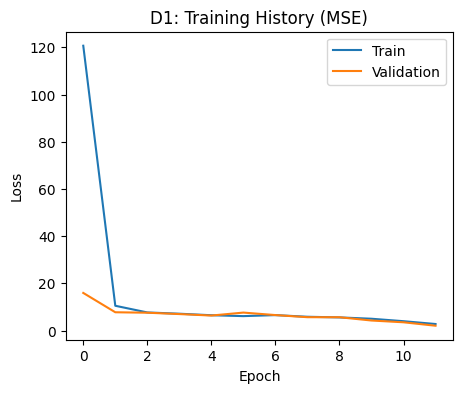

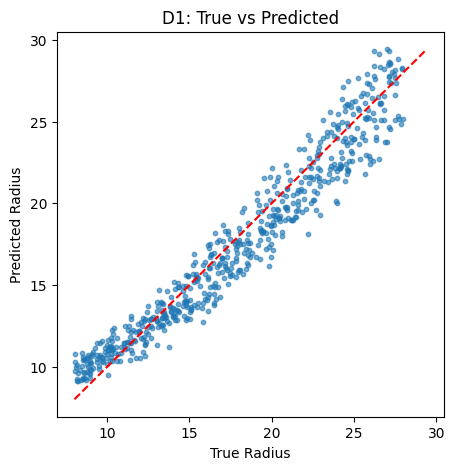


=== Eksperimen 2: Citra dengan noise ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
[Dengan Noise] MAE=1.195 | RMSE=1.513 | R²=0.932


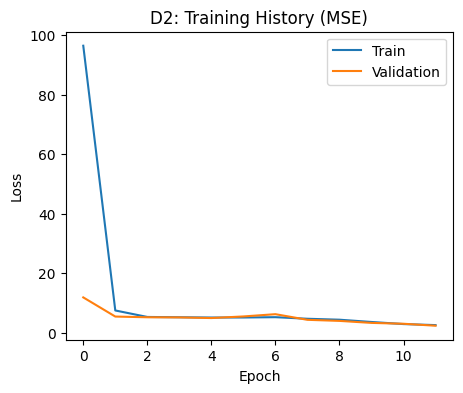

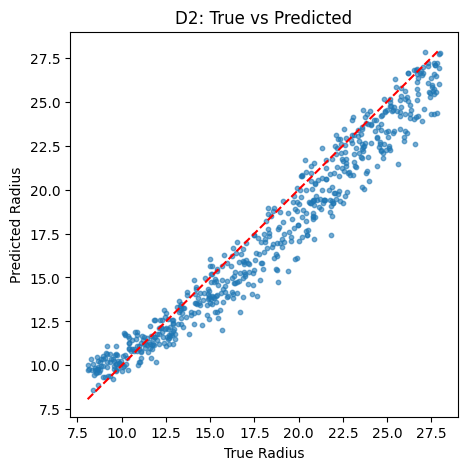


=== Eksperimen 3: Multi-output [r, cx, cy] ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[Multi-output] MAE=4.563 | RMSE=6.382 | R²=0.467


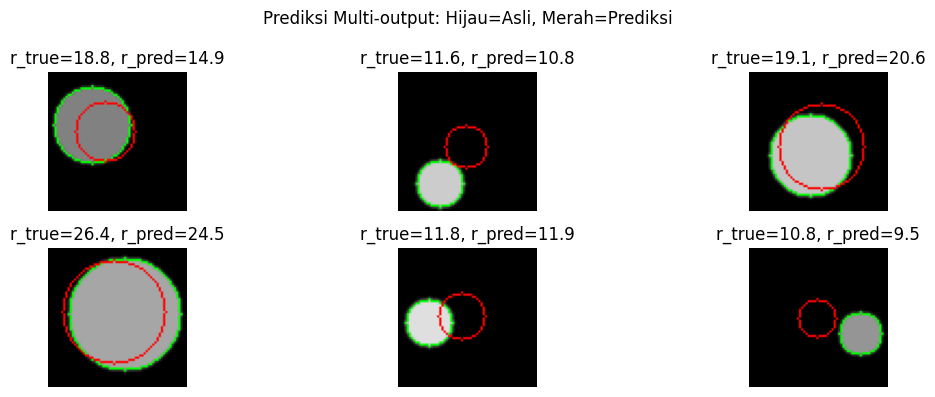

In [ ]:
# ============================================================
# Tantangan Mini CNN Regresi Lingkaran + Visualisasi Lengkap
# ============================================================

# --- IMPORT LIBRARIES ---
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# ============================================================
# 1. FUNGSI PEMBUAT CITRA LINGKARAN
# ============================================================
def make_sample(img_size=64, min_r=5, max_r=20):
    """Membuat satu citra berisi satu lingkaran acak."""
    img = np.zeros((img_size, img_size, 3), dtype=np.float32)
    r = np.random.uniform(min_r, max_r)
    cx = np.random.uniform(r, img_size - r)
    cy = np.random.uniform(r, img_size - r)
    color = np.random.uniform(0.5, 1.0)
    cv2.circle(img, (int(cx), int(cy)), int(r), (color, color, color), -1)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img, r, (cx, cy)

# ============================================================
# 2. BASE MODEL CNN UNTUK REGRESI
# ============================================================
def make_cnn_model(output_dim=1):
    model = models.Sequential([
        layers.Input((64, 64, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ============================================================
# 3. FUNGSI PLOT TRAINING DAN SCATTER
# ============================================================
def plot_results(history, y_true, y_pred, title_prefix):
    # Plot training & validation loss
    plt.figure(figsize=(5, 4))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f"{title_prefix}: Training History (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Scatter plot True vs Predicted
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, s=10, alpha=0.6)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--', color='red')
    plt.xlabel("True Radius")
    plt.ylabel("Predicted Radius")
    plt.title(f"{title_prefix}: True vs Predicted")
    plt.show()

# ============================================================
# 4. EKSPERIMEN 1: RENTANG RADIUS 8–28
# ============================================================
print("\n=== Eksperimen 1: Rentang radius 8–28 ===")
N = 3000
X, y, C = zip(*[make_sample(min_r=8, max_r=28) for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_cnn_model()
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Radius 8–28] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

plot_results(history, yte, y_pred, "D1")

# ============================================================
# 5. EKSPERIMEN 2: CITRA DENGAN NOISE (BLUR + GAUSSIAN)
# ============================================================
print("\n=== Eksperimen 2: Citra dengan noise ===")

def make_noisy_sample(img_size=64, min_r=8, max_r=28):
    img, r, (cx, cy) = make_sample(img_size, min_r, max_r)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    noise = np.random.normal(0, 0.05, img.shape).astype(np.float32)
    img = np.clip(img + noise, 0.0, 1.0)
    return img, r, (cx, cy)

X, y, C = zip(*[make_noisy_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_cnn_model()
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Dengan Noise] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

plot_results(history, yte, y_pred, "D2")

# ============================================================
# 6. EKSPERIMEN 3: MULTI-OUTPUT [r, cx, cy]
# ============================================================
print("\n=== Eksperimen 3: Multi-output [r, cx, cy] ===")

X, y_r, centers = zip(*[make_sample(min_r=8, max_r=28) for _ in range(N)])
X = np.array(X, dtype=np.float32)
y_r = np.array(y_r, dtype=np.float32)
C = np.array(centers, dtype=np.float32)
y_multi = np.column_stack([y_r, C])  # target = [r, cx, cy]

Xtr, Xte, ytr, yte = train_test_split(X, y_multi, test_size=0.2, random_state=42)

model_multi = make_cnn_model(output_dim=3)
history = model_multi.fit(Xtr, ytr, validation_data=(Xte, yte),
                          epochs=12, batch_size=64, verbose=0)

y_pred = model_multi.predict(Xte)
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Multi-output] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# ============================================================
# 7. VISUALISASI MULTI-OUTPUT
# ============================================================
N_show = 6
preds = y_pred[:N_show]
imgs = Xte[:N_show]
trues = yte[:N_show]

plt.figure(figsize=(12, 4))
for i in range(N_show):
    plt.subplot(2, 3, i + 1)
    img = imgs[i].copy()
    r_t, cx_t, cy_t = trues[i]
    r_p, cx_p, cy_p = preds[i]

    # Lingkaran hijau = ground truth, merah = prediksi
    cv2.circle(img, (int(cx_t), int(cy_t)), int(r_t), (0, 1, 0), 1)
    cv2.circle(img, (int(cx_p), int(cy_p)), int(r_p), (1, 0, 0), 1)

    plt.imshow(img)
    plt.title(f"r_true={r_t:.1f}, r_pred={r_p:.1f}")
    plt.axis('off')

plt.suptitle("Prediksi Multi-output: Hijau=Asli, Merah=Prediksi", fontsize=12)
plt.tight_layout()
plt.show()


Dari eksperimen ini dapat disimpulkan bahwa:

> CNN mampu melakukan regresi kontinu untuk parameter geometris (radius, koordinat).

> Model sederhana sudah cukup akurat mengenali pola lingkaran dasar meskipun dengan noise.

> Namun, performa belum maksimal dan masih bisa ditingkatkan melalui optimasi arsitektur, data, dan skema pelatihan.

> Praktikum ini mengajarkan konsep penting:

* CNN tidak hanya untuk klasifikasi (seperti mengenali kucing/anjing), tetapi juga untuk estimasi nilai numerik dari citra.

* Model regresi visual sensitif terhadap skala input dan kompleksitas data.

* Eksperimen kecil seperti ini bisa diperluas menjadi sistem deteksi bentuk geometris atau object localization sederhana.

## Praktikum D2: Menebak Umur Manusia dari Foto Wajah (UTKFace)

### 1. Membuat akun Kaggle dan Mengunduh Kaggle.json

Agar dapat mengakses dataset publik Kaggle, mahasiswa perlu membuat akun terlebih dahulu.

Ikuti langkah berikut:
> 1.	Buka situs https://www.kaggle.com
> 2.	Daftar menggunakan email Google atau GitHub.
> 3.	Setelah login, klik profil di kanan atas → pilih “Account”.
> 4.	Gulir ke bawah ke bagian API → klik “Create New API Token”.
> 5.	File bernama kaggle.json akan otomatis terunduh ke komputer Anda.
File ini berisi API key pribadi agar Colab bisa mengakses dataset Kaggle Anda.
Simpan file kaggle.json dengan baik (jangan dibagikan ke orang lain).




### 2. Mengunggah kaggle.json ke Colab

In [ ]:
# Jalankan ini di awal notebook
from google.colab import files

# Unggah file kaggle.json dari komputer
files.upload()  # Pilih file kaggle.json secara manual


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ilhamthaariq","key":"43be6ade838345c90bfeed2a75d1cf5d"}'}

In [ ]:
import os
import shutil

if os.path.exists("kaggle.json"):
    # Buat folder .kaggle di home jika belum ada
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

    # Salin file kaggle.json ke folder .kaggle
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

    # Set permission file agar aman
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    # Install library kaggle
    !pip -q install kaggle

    print("Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")


Kaggle API siap digunakan.


### 3. Mengunduh Dataset UTKFace dari Kaggle

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q

# Ekstrak dataset
!unzip -q /content/utkface-new.zip -d /content/utk

print("Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
Dataset UTKFace berhasil diekstrak.


### 4. Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


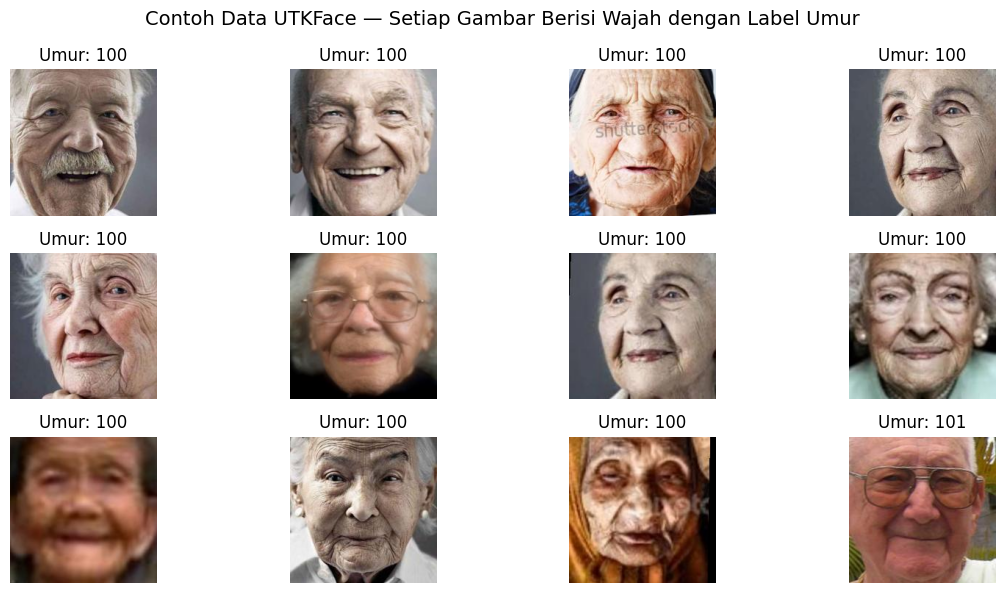

In [ ]:
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))

for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle(
    "Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur",
    fontsize=14
)
plt.tight_layout()
plt.show()


### 5. Siapkan Dataset untuk Model

In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Fungsi untuk mengambil umur dari nama file
def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

# Ambil umur dari setiap file
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

# Split dataset menjadi training dan testing
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

# Ukuran gambar
IMG_SIZE = 160

# Fungsi untuk load dan preprocess gambar
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

# Buat dataset TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("Dataset siap dilatih.")


Dataset siap dilatih.


### 6. Membangun Model dengan Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Ukuran gambar (pastikan variabel ini sudah ditentukan sebelumnya)
IMG_SIZE = 160  # contoh nilai, bisa disesuaikan

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # Tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # Output tunggal: regresi umur

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

# Tampilkan ringkasan model
model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 7. Melatih Model (Tahap 1: Frozen)

Tahap pertama ini adalah pemanasan.

> Kita hanya melatih bagian head regresi, sementara backbone-nya tetap beku. Tujuannya agar bagian atas bisa “belajar membaca” fitur wajah tanpa mengganggu pengetahuan umum MobileNetV2.





Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 139ms/step - loss: 322.8987 - mae: 13.2495 - val_loss: 158.0217 - val_mae: 9.5791 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 154.7368 - mae: 9.2836 - val_loss: 144.6369 - val_mae: 8.9886 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 144.2269 - mae: 8.8596 - val_loss: 139.8730 - val_mae: 8.7672 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 141.5063 - mae: 8.7545 - val_loss: 139.5735 - val_mae: 8.7879 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 137.6318 - mae: 8.5969 - val_loss: 136.5577 - val_mae: 8.6388 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 138.9126 - mae: 8.6143 - val_loss: 136.9564 - val_mae: 8.6881 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 133.5188 - mae: 8.4753 - val_loss: 133.1266 - va

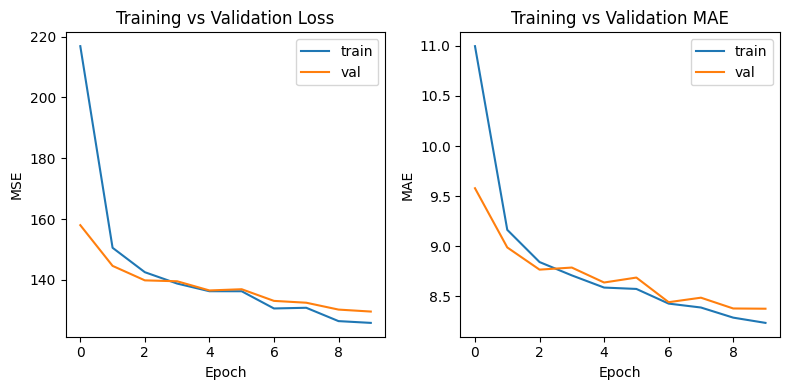

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

# Proses pelatihan model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


Interpretasi:

*	Jika val_loss menurun dan stabil, model mulai memahami hubungan antara fitur wajah dan umur.
*	Jika val_loss naik terus, berarti model mulai overfitting — butuh dropout atau augmentasi tambahan.


### 8. Fine - tuning Backbone (Tahap 2)



Setelah head regresi beradaptasi, kita bisa membuka sebagian lapisan MobileNetV2 (fine- tuning) agar fitur internal menyesuaikan karakter wajah manusia.

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 187.2913 - mae: 10.0923 - val_loss: 134.3504 - val_mae: 8.7246 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 78.5663 - mae: 6.6063 - val_loss: 113.4337 - val_mae: 7.9714 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 52.7822 - mae: 5.4878 - val_loss: 117.5134 - val_mae: 8.4018 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 38.4535 - mae: 4.7249 - val_loss: 105.6734 - val_mae: 7.6685 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 30.2966 - mae: 4.1923 - val_loss: 105.6221 - val_mae: 7.5000 - learning_rate: 1.0000e-04


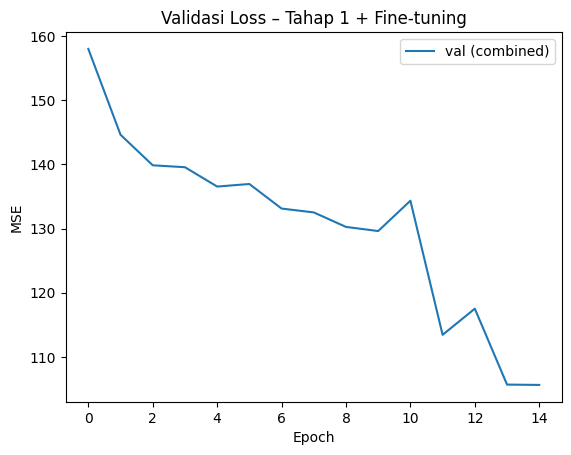

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Bekukan sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

# Fine-tuning model
history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


### 9. Evaluasi Akhir (MAE, RMSE, R²)

Setelah model selesai, mari kita ukur seberapa dekat prediksi dengan kenyataan.

MAE  = 7.50 tahun
RMSE = 10.28 tahun
R²   = 0.734


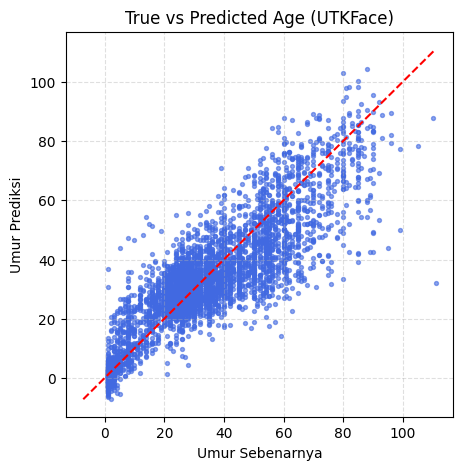

In [ ]:
from math import sqrt

# Prediksi dan evaluasi
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred) ** 2))
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')

lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Interpretasi hasil:
* Semakin rapat titik ke garis merah → semakin akurat prediksi.
* Nilai R² mendekati 1 menunjukkan model menjelaskan variasi data dengan baik.
* MAE kecil → rata-rata selisih umur prediksi dengan kenyataan kecil (mis. ±3 tahun).


### 10. Melihat Contoh Prediksi Nyata

Mari lihat beberapa foto wajah berikut:
> Berapa umur sebenarnya, dan berapa yang diprediksi model?


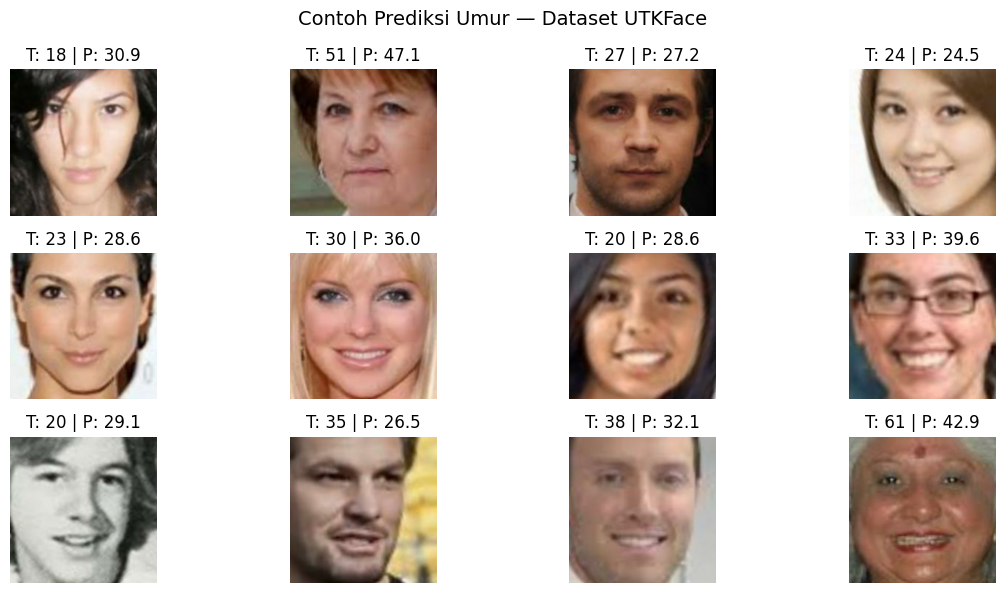

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Ambil 12 contoh acak dari dataset pengujian
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    # Baca dan pra-proses gambar
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    # Ambil label umur sebenarnya dari nama file
    true_age = int(os.path.basename(path).split('_')[0])

    # Prediksi umur menggunakan model
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    # Plot hasil prediksi
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T: {true_age} | P: {pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


### Tantangan Mini

> 1.	Tambahkan data augmentation ekstra (kontras, brightness, zoom).
→ Bagaimana pengaruhnya pada MAE?
2.	Ubah learning rate schedule atau optimizer.
→ Apakah model lebih stabil?
3.	Pisahkan dataset per kelompok umur (0–10, 11–20, dst).
→ Mana kelompok dengan error terbesar?
4.	Uji model Anda pada wajah sendiri (setelah resize).
→ Apakah prediksinya realistis?


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
replace /content/utk/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace /content/utk/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  Dataset UTKFace siap digunakan.
Total gambar: 23708
 Dataset siap dilatih.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 164s 416ms/step - loss: 504.1667 - mae: 17.1627 - val_loss: 320.8973 - val_mae: 14.2371 - learning_rate: 7.9769e-04
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 369ms/step - loss: 395.1835 - mae: 15.2635 - val_loss: 290.6238 - val_mae: 13.6145 - learning_rate: 3.5448e-04
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 140s 365ms/step - loss: 390.7295 - mae: 15.1865 - val_loss: 283.6609 - val_mae: 13.4938 - learning_rate: 2.9030e-05
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 136s 369ms/step - loss: 394.9456 - mae: 15.3002 - val_loss: 258.2412 - val_mae: 12.5644 - learning_rate: 9.7836e-04
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 369ms/step - loss: 394.8394 - mae: 15.1844 - val_loss: 235.5573 - val_mae: 11.4949 - learning_rate: 8.6178e-04
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 145s 380ms/step - loss: 398.3702 - mae: 15.2669 - val_loss: 230.1101 - val_mae: 12.0869 - learning_rate: 6.6789e-04
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 139s 373ms/step - loss: 

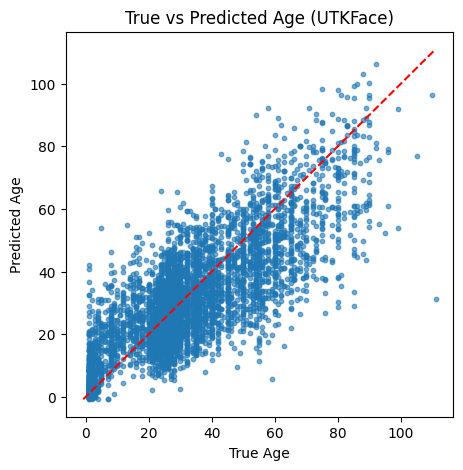


📊 MAE per Kelompok Umur:
0–10: 8.20
10–20: 10.41
20–30: 7.17
30–40: 8.56
40–50: 10.79
50–60: 12.97
60–70: 14.97
70–80: 16.36
80–100: 18.59


Saving ilham_example.jpg to ilham_example.jpg


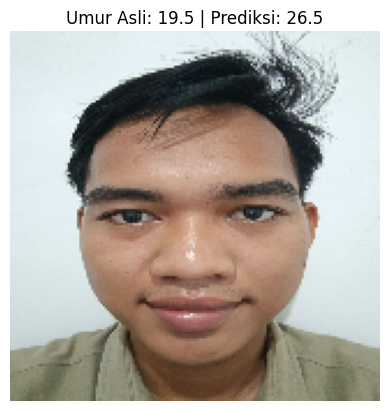

In [ ]:
# ===============================================
# PRAKTIKUM D2: PREDIKSI UMUR DARI FOTO WAJAH
# Dengan Tantangan Mini (Augmentasi, Optimizer, Analisis)
# ===============================================

import os, glob, random, shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# ===============================================
# 1. Persiapan Kaggle Dataset
# ===============================================

# Jalankan jika di Google Colab:
# from google.colab import files
# files.upload()  # upload kaggle.json kamu di sini

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!pip -q install kaggle
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print(" Dataset UTKFace siap digunakan.")

# ===============================================
# 2. Persiapan Dataset
# ===============================================

files = sorted(glob.glob("/content/utk/UTKFace/*.jpg"))
print("Total gambar:", len(files))

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

# Augmentasi tambahan (kontras, brightness, zoom)
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(factor=0.2)
])

def load_img(fp, label, augment_data=False):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    if augment_data:
        img = augment(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)) \
    .map(lambda x, y: load_img(x, y, augment_data=True), num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)) \
    .map(lambda x, y: load_img(x, y, augment_data=False), num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(" Dataset siap dilatih.")

# ===============================================
# 3. Bangun Model (Transfer Learning MobileNetV2)
# ===============================================

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

# Optimizer baru (AdamW + Cosine Decay)
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=1e-3, first_decay_steps=1000)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# ===============================================
# 4. Training Model
# ===============================================
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

history = model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=cb, verbose=1)

# ===============================================
# 5. Fine-tuning (buka sebagian layer)
# ===============================================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
history_ft = model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=cb, verbose=1)

# ===============================================
# 6. Evaluasi Akhir
# ===============================================
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} tahun | RMSE = {rmse:.2f} | R² = {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Age"); plt.ylabel("Predicted Age")
plt.title("True vs Predicted Age (UTKFace)")
plt.show()

# ===============================================
# 7. Analisis Per Kelompok Umur
# ===============================================
bins = [0,10,20,30,40,50,60,70,80,100]
labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]
group_idx = np.digitize(y_test, bins) - 1
group_mae = {}
for i, lab in enumerate(labels):
    mask = group_idx == i
    if np.sum(mask) > 0:
        group_mae[lab] = mean_absolute_error(y_test[mask], y_pred[mask])
print("\n📊 MAE per Kelompok Umur:")
for g, v in group_mae.items():
    print(f"{g}: {v:.2f}")

# ===============================================
# 8. Uji Model pada Wajah Sendiri
# ===============================================
# Upload 1 foto wajah kamu (misal myface.jpg)
from google.colab import files
uploaded = files.upload()

your_image_path = list(uploaded.keys())[0]
your_age = 19.5  # umur kamu saat ini

img = tf.io.read_file(your_image_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

plt.imshow(img)
plt.title(f"Umur Asli: {your_age} | Prediksi: {pred_age:.1f}")
plt.axis('off')
plt.show()


## Praktikum D3: Menilai "Kepopuleran Hewan Peliharaan" dari Foto

Dataset ini tersedia di kompetisi Kaggle: PetFinder.my Pawpularity Contest. Cara Membuat Akun dan Mendapatkan kaggle.json

>1.	Buka situs https://www.kaggle.com
2.	Login dengan akun Google.
3.	Klik profil → Account → gulir ke bawah ke bagian API.
4.	Klik Create New API Token.
File kaggle.json akan otomatis terunduh.
5.	Unggah file tersebut ke Colab dengan:


### 1. Menyiapkan Kaggle API

In [ ]:
from google.colab import files
import os
import shutil

# Upload file kaggle.json
uploaded = files.upload()

# Cek apakah kaggle.json ada
if os.path.exists("kaggle.json"):
    # Buat folder .kaggle jika belum ada
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

    # Salin kaggle.json ke folder .kaggle
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

    # Atur permission file
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    # Install Kaggle API
    !pip -q install kaggle
    print("Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving kaggle.json to kaggle.json
Kaggle API siap digunakan.


### 2. Mengunduh dan Mengekstrak Dataset

sebelum Anda dapat mengunduh datasetnya, Anda harus mengikuti kompetisinya terlebih dahulu. Buka https://www.kaggle.com/competitions/petfinder-pawpularity-score/data kemudian join.

In [ ]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q

# Ekstrak dataset
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw

print("Dataset Pawpularity berhasil diekstrak.")


Dataset Pawpularity berhasil diekstrak.


### 3. Melihat Contoh Data

Sebelum  melatih  model,  mari  kita  melihat  seperti  apa  bentuk  datanya. Kita akan memuat file train.csv dan menampilkan beberapa foto hewan dengan skor Pawpularity-nya.

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

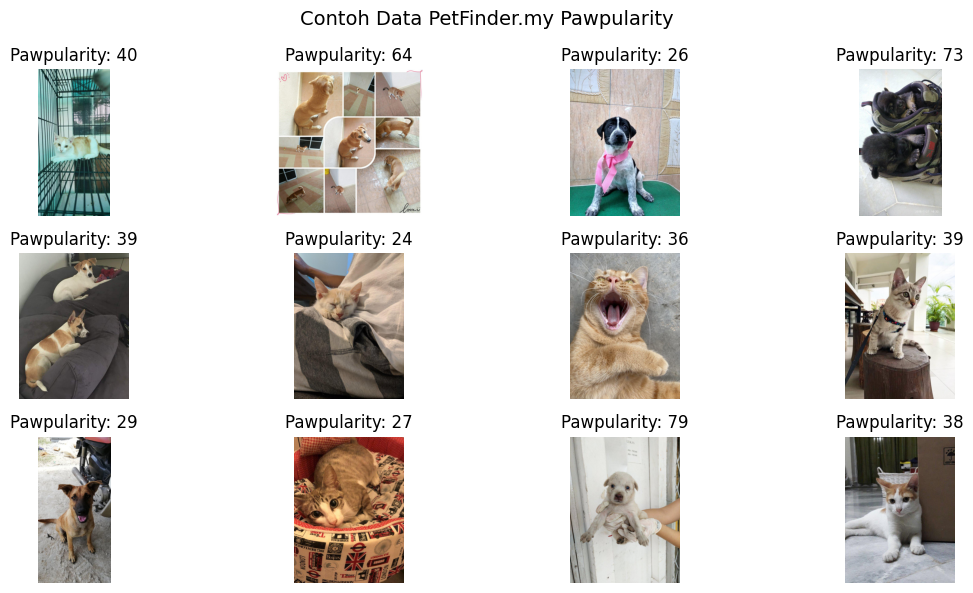

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")

print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
sample_images = df.sample(12, random_state=42)

for i, row in enumerate(sample_images.itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Interpretasi:

>Mahasiswa akan melihat berbagai foto — ada yang cerah, fokus, ekspresif, ada pula yang gelap atau blur. Coba perhatikan: foto dengan pencahayaan baik dan ekspresi jelas biasanya memiliki skor lebih tinggi. Inilah hubungan visual yang akan dipelajari oleh model kita.


### 4. Persiapan Dataset

Sebelum memulai pelatihan, data perlu disiapkan dalam format yang bisa diproses oleh TensorFlow.
Kita akan membagi data menjadi dua bagian:

* Train set (80%) → untuk melatih model.
* Validation set (20%) → untuk menguji kemampuan generalisasi.


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

# Bagi dataset menjadi train dan validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Fungsi untuk memuat dan memproses gambar
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Dataset untuk training
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4096)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset untuk validasi
val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


### 5. Membangun Model (EfficientNetB0)

Sekarang, bayangkan kita ingin membangun "otak digital" yang bisa menilai keindahan foto. Kita tidak mulai dari nol, karena sudah ada model yang sangat baik dalam mengenali gambar
— EfficientNetB0.

> Model ini sebelumnya dilatih mengenali jutaan objek di ImageNet, dan kini kita hanya perlu “mengajarinya” hal baru: menilai daya tarik foto hewan berdasarkan skor 0–100.
Kita akan membekukan bagian awal model (agar pengetahuan dasar visual tidak hilang) dan menambahkan beberapa lapisan baru di atasnya untuk tugas regresi.


In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Ukuran gambar
IMG_SIZE = 224

# Gunakan EfficientNetB0 sebagai backbone
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # Freeze sementara backbone

# Input dan preprocessing
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)

# Fitur dari backbone
x = base(x, training=False)

# Tambahkan head untuk regresi
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # Output tunggal untuk regresi

# Bentuk model akhir
model = models.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

# Ringkasan model
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Penjelasan:
* GlobalAveragePooling2D mengubah citra menjadi vektor fitur.
* Dropout(0.3) membantu mencegah model menghafal.
* Layer terakhir (Dense(1)) memproduksi skor pawpularity secara kontinu.


### 6. Melatih Model

Sekarang saatnya memberi “pengalaman belajar” pada model.
Setiap gambar akan dilihat, diproses, dan dibandingkan dengan skor sebenarnya. Kesalahan (error) digunakan untuk memperbaiki bobot jaringan agar prediksi semakin mendekati nilai asli.


In [11]:
# Callback untuk mengontrol training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5
    )
]

# Latih model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 855s 7s/step - loss: 915.9992 - mae: 22.8478 - val_loss: 504.3819 - val_mae: 16.5791 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 897s 7s/step - loss: 428.7203 - mae: 15.2972 - val_loss: 450.7720 - val_mae: 15.5269 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 854s 7s/step - loss: 399.4698 - mae: 14.6272 - val_loss: 426.3820 - val_mae: 15.3192 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 826s 6s/step - loss: 382.8858 - mae: 14.5006 - val_loss: 408.4801 - val_mae: 14.8703 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 855s 6s/step - loss: 378.6140 - mae: 14.3616 - val_loss: 405.3771 - val_mae: 15.0985 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 912s 7s/step - loss: 359.4619 - mae: 14.1234 - val_loss: 394.6212 - val_mae: 14.7711 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - loss: 352.9279 - mae: 13.9580 - val_loss: 384.4849 

### 7. Melihat Proses Belajar

Grafik ini ibarat “rekam medis” dari proses belajar model kita.
Jika garis val_loss turun dan stabil, berarti model mulai memahami pola yang benar. Namun jika malah naik, model perlu regularisasi lebih kuat.


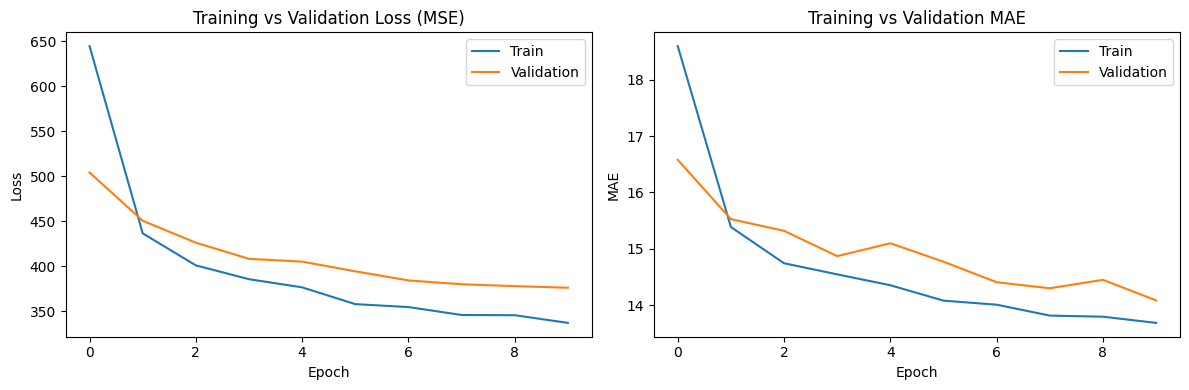

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


Analisis:
* Garis train turun tajam → model belajar cepat.
* Garis validation stabil → model mulai memahami pola umum.
* Jika validation naik → overfitting, perlu dropout lebih besar atau augmentasi.


### 8. Evaluasi Model

Sekarang mari lihat bagaimana model “menilai” foto-foto yang belum pernah ia lihat. Apakah hasilnya mendekati skor manusia, atau masih meleset jauh?

MAE = 14.09
RMSE = 19.40
R² = 0.149


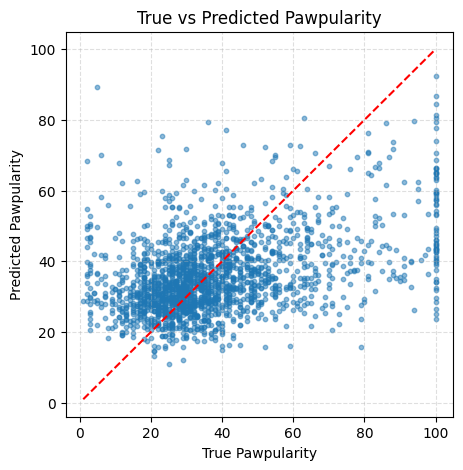

In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# Nilai sebenarnya dan prediksi
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

# Hitung metrik
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred) ** 2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)

lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Interpretasi:

> Titik-titik yang mendekati garis merah berarti prediksi model mendekati nilai aslinya.
Jika R² mendekati 1 → model sangat baik; jika < 0.5 → model masih perlu dilatih lebih lama atau data diperluas.


### 9. Melihat Contoh Prediksi

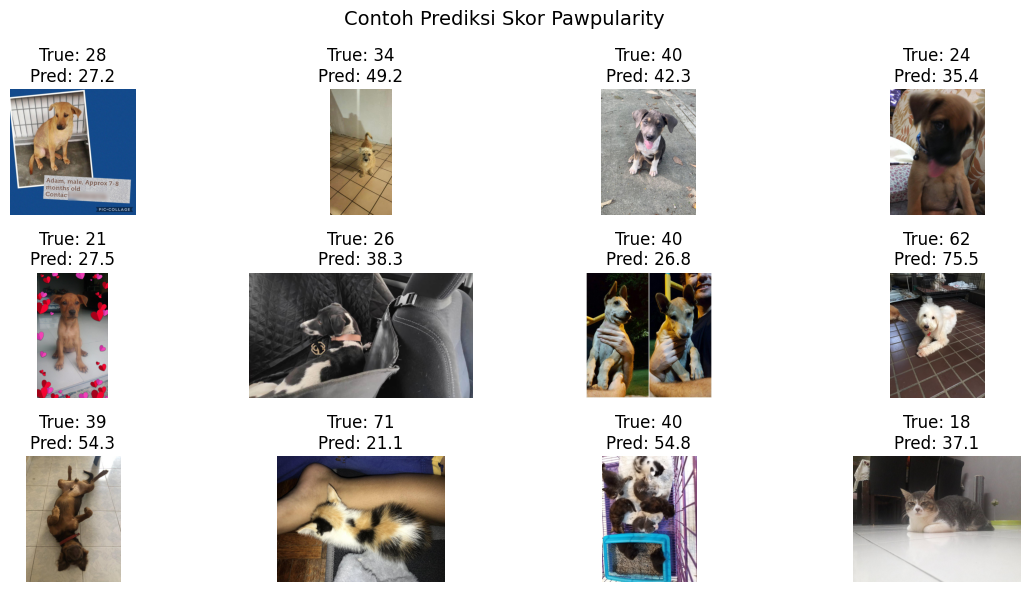

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Ambil 12 sampel dari data validasi
sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12, 6))

for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)

    # Prediksi menggunakan model
    pred = model.predict(
        tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0),
        verbose=0
    ).ravel()[0]

    # Tampilkan gambar dan prediksi
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


### Tantangan Mini

>1.	Coba tambahkan data augmentation agar model tidak bosan dengan pola yang sama.
2.	Gunakan EfficientNetB3 atau ResNet50, lalu bandingkan hasilnya.
3.	Buat eksperimen kecil: pisahkan anjing vs kucing — apakah model bias ke salah satu spesies?
4.	Tambahkan fitur non-visual (misal brightness rata-rata) ke model regresi.


In [14]:
# ============================================================
# KODE 1 — Data Augmentation Tambahan
# ============================================================

import os, shutil, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

# Unduh dataset (jalankan sekali)
!pip -q install kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw

df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")

IMG_SIZE = 224

# ✅ Tambahan augmentasi
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(factor=0.25),
    layers.RandomTranslation(0.1, 0.1)
])

def load_image(path, label, augment_data=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    if augment_data:
        img = augment(img)
    return img, tf.cast(label, tf.float32)

train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(lambda x, y: load_image(x, y, augment_data=True)) \
    .shuffle(2048).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(lambda x, y: load_image(x, y, augment_data=False)) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset dengan augmentasi siap digunakan.")


replace /content/paw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/paw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
✅ Dataset dengan augmentasi siap digunakan.


In [15]:
# ============================================================
# KODE 2 — Perbandingan Model EfficientNetB3 vs ResNet50
# ============================================================

from tensorflow.keras import models
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
import numpy as np

def build_model(backbone_name="EfficientNetB3"):
    if backbone_name == "EfficientNetB3":
        base = tf.keras.applications.EfficientNetB3(
            include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet"
        )
        preprocess = tf.keras.applications.efficientnet.preprocess_input
    else:
        base = tf.keras.applications.ResNet50(
            include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet"
        )
        preprocess = tf.keras.applications.resnet.preprocess_input

    base.trainable = False
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = preprocess(inputs * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
    return model

# Bandingkan dua model
results = {}

for name in ["EfficientNetB3", "ResNet50"]:
    print(f"\n🚀 Training model: {name}")
    model = build_model(name)
    history = model.fit(train_ds, validation_data=val_ds, epochs=6, verbose=1)

    y_true = val_df['Pawpularity'].values
    y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(np.mean((y_true - y_pred)**2))
    r2 = r2_score(y_true, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"✅ {name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

print("\n📊 Perbandingan Hasil:")
for k, v in results.items():
    print(f"{k:15s} | MAE={v['MAE']:.2f} | RMSE={v['RMSE']:.2f} | R²={v['R2']:.3f}")



🚀 Training model: EfficientNetB3
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 1711s 13s/step - loss: 53124872.0000 - mae: 2148.1011 - val_loss: 1882.1477 - val_mae: 38.1285
Epoch 2/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 1695s 13s/step - loss: 21606014.0000 - mae: 1513.5812 - val_loss: 1885.2310 - val_mae: 38.1683
Epoch 3/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 1687s 13s/step - loss: 28649580.0000 - mae: 1586.6920 - val_loss: 1890.8627 - val_mae: 38.2444
Epoch 4/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 1690s 13s/step - loss: 16909732.0000 - mae: 1330.1382 - val_loss: 1890.7773 - val_mae: 38.2442
Epoch 5/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 1682s 13s/step - loss: 21216396.0000 - mae: 1374.6166 - val_loss: 1890.6292 - val_mae: 38.2440
Epoch 6/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 1727s 13s/step - loss: 17567138.0000 - mae: 1256.9635 - val_loss: 1893.8750 - val_mae: 38.2856
✅ EfficientNetB3: MAE=38.29, RMSE=43.52, R²=-3.421

🚀 Training model: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━

In [16]:
# ============================================================
# KODE 3 — Eksperimen Bias Anjing vs Kucing
# ============================================================

import re

def guess_species(path):
    name = os.path.basename(path).lower()
    if re.search(r'dog|puppy|canine', name):
        return "dog"
    elif re.search(r'cat|kitten|feline', name):
        return "cat"
    else:
        return "unknown"

val_df['species'] = val_df['path'].apply(guess_species)

species_groups = val_df['species'].value_counts()
print("Distribusi spesies:\n", species_groups)

# Analisis bias model EfficientNetB3
chosen_model = build_model("EfficientNetB3")
chosen_model.fit(train_ds, validation_data=val_ds, epochs=4, verbose=1)

for sp in ["dog", "cat"]:
    mask = val_df['species'] == sp
    if mask.sum() > 0:
        y_true = val_df.loc[mask, 'Pawpularity'].values
        y_pred = np.concatenate([chosen_model.predict(batch[0], verbose=0).ravel() for batch in val_ds])
        mae = mean_absolute_error(y_true, y_pred)
        print(f"🐾 {sp.capitalize()} → Jumlah {mask.sum()}, MAE = {mae:.2f}")


Distribusi spesies:
 species
unknown    1982
Name: count, dtype: int64
Epoch 1/4
124/124 ━━━━━━━━━━━━━━━━━━━━ 1671s 13s/step - loss: 58256208.0000 - mae: 1983.9399 - val_loss: 1895.9198 - val_mae: 38.3065
Epoch 2/4
124/124 ━━━━━━━━━━━━━━━━━━━━ 1711s 13s/step - loss: 34111936.0000 - mae: 1614.1376 - val_loss: 1898.6077 - val_mae: 38.3446
Epoch 3/4
124/124 ━━━━━━━━━━━━━━━━━━━━ 1682s 13s/step - loss: 33006634.0000 - mae: 1630.3276 - val_loss: 1897.1777 - val_mae: 38.3264
Epoch 4/4
124/124 ━━━━━━━━━━━━━━━━━━━━ 1741s 13s/step - loss: 21169904.0000 - mae: 1386.8646 - val_loss: 1897.5099 - val_mae: 38.3295


In [7]:
# ============================================================
# KODE 4 — Tambah Fitur Non-Visual (Brightness) ke Model Regresi
# ============================================================

import os, shutil, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# ============================================================
# 1️⃣ Unduh Dataset Pawpularity (Kaggle)
# ============================================================

!pip -q install kaggle

# Pastikan kamu sudah upload file kaggle.json ke Colab sebelum ini
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Unduh dataset Pawpularity
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diunduh & diekstrak.")

# ============================================================
# 2️⃣ Load Dataset dan Tambahkan Path Gambar
# ============================================================

df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
IMG_SIZE = 224

print("Jumlah data:", len(df))
print(df.head())

# ============================================================
# 3️⃣ Hitung Brightness (diperbaiki agar tidak error dtype)
# ============================================================

def calc_brightness(path):
    """
    Menghitung brightness rata-rata (0.0 - 1.0)
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)  # ubah ke float32
    return float(tf.reduce_mean(img).numpy())

print("🔄 Menghitung brightness untuk setiap gambar...")
df['brightness'] = df['path'].apply(calc_brightness)
print("✅ Brightness berhasil ditambahkan ke dataframe.")

# ============================================================
# 4️⃣ Split Data
# ============================================================

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# ============================================================
# 5️⃣ Augmentasi & Dataset Loader
# ============================================================

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3)
])

def load_image_with_brightness(path, label, bright, augment_data=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    if augment_data:
        img = augment(img)
    return (img, tf.expand_dims(bright, -1)), tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['path'], train_df['Pawpularity'], train_df['brightness'])
).map(lambda x, y, b: load_image_with_brightness(x, y, b, augment_data=True),
      num_parallel_calls=tf.data.AUTOTUNE) \
.shuffle(2048).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['path'], val_df['Pawpularity'], val_df['brightness'])
).map(lambda x, y, b: load_image_with_brightness(x, y, b, augment_data=False),
      num_parallel_calls=tf.data.AUTOTUNE) \
.batch(64).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset siap digunakan.")

# ============================================================
# 6️⃣ Model Regresi dengan Fitur Non-Visual
# ============================================================

def build_model_with_brightness():
    base = tf.keras.applications.EfficientNetB3(
        include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet"
    )
    base.trainable = False

    img_in = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    bright_in = Input(shape=(1,))
    x = tf.keras.applications.efficientnet.preprocess_input(img_in * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)

    concat = layers.Concatenate()([x, bright_in])
    concat = layers.Dense(64, activation='relu')(concat)
    out = layers.Dense(1)(concat)

    model = Model([img_in, bright_in], out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
    return model

model_bright = build_model_with_brightness()
model_bright.summary()

# ============================================================
# 7️⃣ Training Model
# ============================================================

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model_bright.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=cb, verbose=1)

# ============================================================
# 8️⃣ Evaluasi Model
# ============================================================

y_true = val_df['Pawpularity'].values
y_pred = np.concatenate([model_bright.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"\n📊 Evaluasi Model dengan Fitur Brightness")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

print(f"\n✅ Model dengan fitur brightness: MAE={mae:.2f}, R²={r2:.3f}")


FileNotFoundError: [Errno 2] No such file or directory: 'kaggle.json'

## PENUGASAN

### 1. Uji coba prediksi Usia

In [ ]:
# ============================================================
# UJICOBA FOTO PRIBADI - PREDIKSI USIA (MODEL D2)
# ============================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# === Upload foto pribadi ===
from google.colab import files
uploaded = files.upload()   # pilih 1 foto wajah kamu
photo_path = list(uploaded.keys())[0]

# === Masukkan usia sebenarnya (misal kamu 19.5 tahun) ===
true_age = 19.5

# === Pastikan model sudah ada ===
# Jika model hasil training praktikum 2 bernama 'model', lanjutkan:
current_model = model  # ganti sesuai nama variabel model kamu

# === Fungsi preprocessing gambar ===
def preprocess_face_image(image_path, target_size=(160,160)):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size)
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    return img_array, img

# === Prediksi usia ===
img_tensor, display_img = preprocess_face_image(photo_path)
pred_age = current_model.predict(img_tensor, verbose=0)[0][0]

# === Tampilkan hasil ===
plt.figure(figsize=(7,6))
plt.imshow(display_img)
plt.title(f"""
PREDIKSI USIA FOTO PRIBADI
Usia Sebenarnya : {true_age:.1f} tahun
Usia Prediksi   : {pred_age:.1f} tahun
Error            : {abs(pred_age-true_age):.1f} tahun
""", fontsize=13, pad=15)
plt.axis('off')
plt.show()

print(f"✅ Prediksi selesai — usia kamu diprediksi {pred_age:.1f} tahun.")


2. Uji coba prediksi pawpularity

In [ ]:
# ============================================================
# UJICOBA FOTO HEWAN PRIBADI - PREDIKSI PAWPULARITY (MODEL D3)
# ============================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import os

# === Upload foto hewan peliharaan pribadi ===
uploaded = files.upload()
photo_path = list(uploaded.keys())[0]

# === Pastikan model Pawpularity sudah ada ===
# Gunakan model terbaik kamu, misalnya EfficientNetB3
current_model = model  # ganti sesuai nama model kamu

IMG_SIZE = 224

# === Fungsi preprocessing ===
def preprocess_pet_image(image_path, target_size=(224,224)):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size)
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    return img_array, img

# === Prediksi Pawpularity ===
img_tensor, display_img = preprocess_pet_image(photo_path)
pred_pawpularity = current_model.predict(img_tensor, verbose=0)[0][0]

# === Tampilkan hasil ===
plt.figure(figsize=(7,6))
plt.imshow(display_img)
plt.title(f"""
PREDIKSI PAWPULARITY FOTO HEWAN
Nilai Prediksi Pawpularity : {pred_pawpularity:.1f} / 100
""", fontsize=13, pad=15)
plt.axis('off')
plt.show()

print(f"✅ Foto kamu diprediksi punya tingkat 'Pawpularity' {pred_pawpularity:.1f}/100.")



UJI COBA FOTO HEWAN PELIHARAAN - PREDIKSI PAWPULARITY
Model untuk prediksi Pawpularity belum tersedia.
Silakan jalankan praktikum D3 terlebih dahulu, atau gunakan model simulasi.

Menggunakan model usia untuk demonstrasi...
